

#### Model Parameters
- Beta
- Gamma
- Mu


#### Network Parameters
- Node Number
- Edge Number
- Rewiring Probability (Watts-Strogatz)
- Edge Probability (Erdose-Reyni)


#### Network statistics
- Centrality
- Degree Distribution
- Clustering
- Shortest Path
- Diameter
- Density
- Assortativity


In [1082]:
import numpy as np # Numerical Operations
import networkx as nx # Network Analysis
import ndlib.models.ModelConfig as mc # Network Model Configuration
import ndlib.models.epidemics as ep # Epidemic Networks
import dataclasses # Dataclasses
import matplotlib.pyplot as plt # Plotting
from matplotlib import cm # Colormaps
import pandas as pd # Dataframes
from matplotlib.animation import FuncAnimation
from PIL import Image
from functools import partial
import random

In [1083]:
def networkFromCSV(filePath):
    dataSet = pd.read_csv(filePath, index_col = 0, delimiter=';') 

    dataSet.columns = dataSet.index

    network = nx.from_pandas_adjacency(dataSet)

    return network

In [1085]:
def plotNetwork(network, title, layout, colors, withLabels = True):
    plt.figure(figsize=(12, 8))

    plt.clf()

    nx.draw(network, 
            pos = layout, 
            node_size = 30, 
            node_color = colors, 
            edge_color = 'grey', 
            width = 0.25,
            font_size = 6,
            with_labels = withLabels) 

    plt.title(title, fontsize=15)

    plt.show()

In [1086]:
def plotSingleNetworkInfection(t, modelIterations, network, layout, colors, colorDictionary, title):
    plt.clf()

    plt.title(title + ' at time ' + str(t), fontsize=15)
    
    for node in modelIterations[t]['status']:
        if modelIterations[t]['status'][node] == 0:
            colorDictionary[node] = 'blue'
        elif modelIterations[t]['status'][node] == 1:
            colorDictionary[node] = 'red'
        else:
            colorDictionary[node] = 'green'

    colors = [colorDictionary[node] for node in network.nodes()]

    nx.draw(network, 
            pos = layout, 
            node_size = 30, 
            node_color = colors, 
            edge_color = 'grey', 
            width = 0.25,
            font_size = 6,
            with_labels = False) 

## Network Initialization

In [1088]:
sociopatternsNetwork = networkFromCSV('transmission_network.csv')

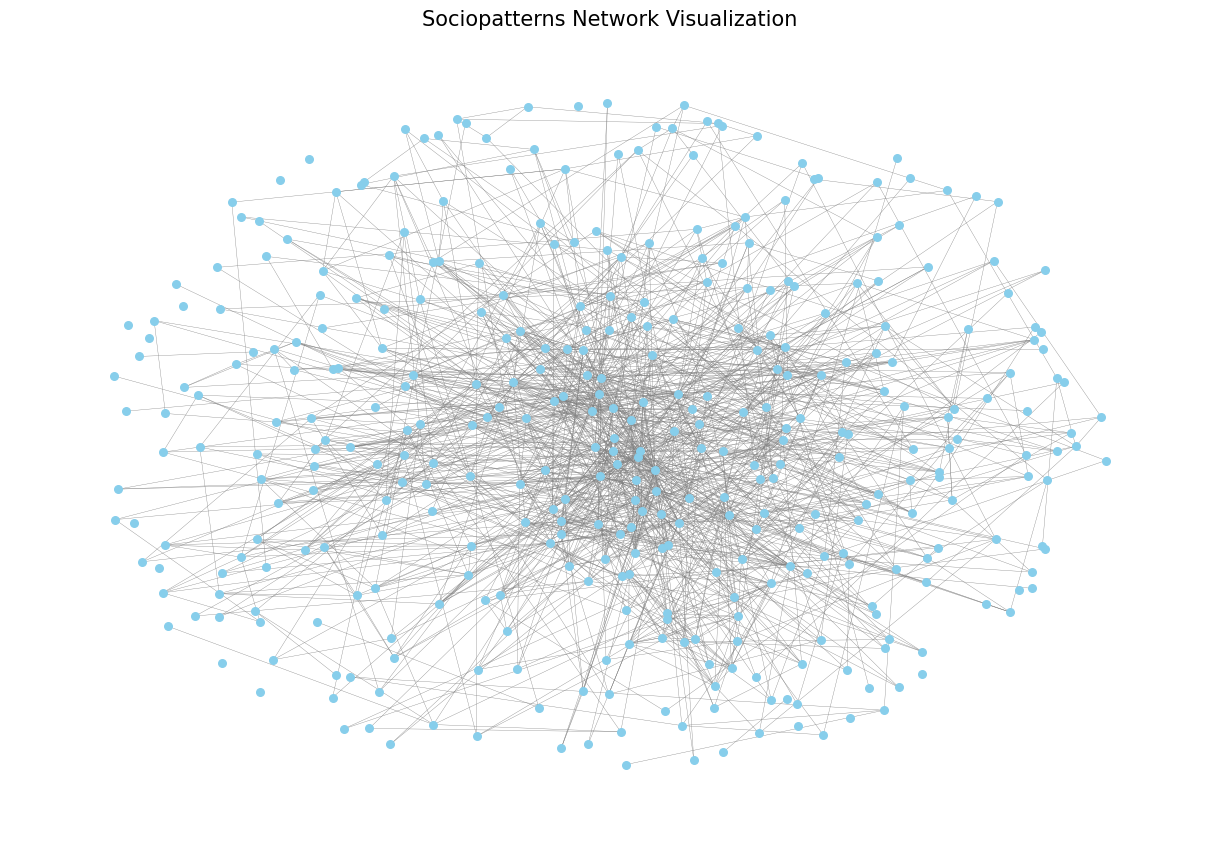

In [1089]:
springLayout = nx.spring_layout(sociopatternsNetwork, k=1.5)

plotNetwork(sociopatternsNetwork, 
            'Sociopatterns Network Visualization', 
            springLayout, 
            'skyblue', 
            withLabels = False)

## Null Vaccination Simulation

In [1090]:
beta = 0.11
gamma = 0.1

In [1091]:
timeMax = 100
timeMin = 0
timeInterval = 1
timeSpan = np.arange(timeMin, timeMax, timeInterval)

In [1092]:
infectedNodesRandom = []

while len(infectedNodesRandom) < 5:
    randomIndex = np.random.choice(sociopatternsNetwork.nodes())
    if randomIndex not in infectedNodesRandom:
        infectedNodesRandom.append(randomIndex)
    print(randomIndex)

1754
1716
1452
1583
1901


In [1093]:
VACC_NUM = 10

sociopatternsNullSIR = ep.SIRModel(sociopatternsNetwork)

modelConfig = mc.Configuration()
modelConfig.add_model_parameter('beta', beta)
modelConfig.add_model_parameter('gamma', gamma)
# modelConfig.add_model_parameter('Infected', infectedNodesRandom)
modelConfig.add_model_parameter("fraction_infected", 0.0)

for n in sociopatternsNetwork.nodes():
    modelConfig.add_node_configuration("Infected", n, 0)

vaccinationArray = list(sociopatternsNetwork.nodes())
random.shuffle(vaccinationArray)
print(vaccinationArray)

for i in infectedNodesRandom:
    sociopatternsNullSIR.status[i] = 1
sociopatternsNullSIR.set_initial_status(modelConfig)

S_list = []
I_list = []
R_list = []

iterations = []

title = 'Sociopatterns Network SIR Model'
saveName = 'sociopatternsSIRModel.gif'

for i in timeSpan:
    vaccDict = {}
    for vacc in range(VACC_NUM):
        if len(vaccinationArray) > 0:
            vaccCandidate = vaccinationArray.pop()
            if sociopatternsNullSIR.status[vaccCandidate] == 0:
                sociopatternsNullSIR.status[vaccCandidate] = 2
                vaccDict[vaccCandidate] = 2
    iteration = sociopatternsNullSIR.iteration()
    for vacc in vaccDict:
        iteration['status'][vacc] = vaccDict[vacc]
    S_list.append(iteration['node_count'][0])
    I_list.append(iteration['node_count'][1])
    R_list.append(iteration['node_count'][2])

    iterations.append(iteration)

[1848, 1885, 1537, 1791, 1505, 1816, 1851, 1898, 1668, 1911, 1789, 1757, 1616, 1485, 1667, 1555, 1871, 1503, 1622, 1783, 1868, 1458, 1805, 1535, 1643, 1647, 1492, 1839, 1455, 1638, 1441, 1798, 1773, 1599, 1769, 1673, 1435, 1605, 1499, 1681, 1845, 1685, 1564, 1603, 1858, 1808, 1531, 1576, 1487, 1716, 1907, 1512, 1426, 1521, 1652, 1582, 1546, 1479, 1575, 1549, 1591, 1460, 1558, 1482, 1491, 1887, 1513, 1807, 1768, 1920, 1519, 1434, 1634, 1821, 1701, 1465, 1819, 1695, 1592, 1893, 1541, 1562, 1680, 1614, 1461, 1566, 1554, 1732, 1551, 1464, 1702, 1602, 1626, 1675, 1630, 1712, 1770, 1704, 1475, 1767, 1811, 1724, 1747, 1655, 1623, 1583, 1742, 1452, 1560, 1698, 1699, 1649, 1835, 1771, 1666, 1628, 1727, 1877, 1850, 1703, 1901, 1480, 1876, 1651, 1866, 1490, 1718, 1854, 1527, 1442, 1440, 1548, 1613, 1467, 1577, 1648, 1916, 1532, 1476, 1439, 1689, 1593, 1875, 1520, 1803, 1684, 1853, 1601, 1855, 1774, 1841, 1766, 1530, 1707, 1792, 1917, 1438, 1473, 1570, 1552, 1462, 1453, 1892, 1834, 1787, 1713, 166

C:\Users\Victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ndlib\models\DiffusionModel.py:169: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  warnings.warn(


In [1094]:
colorDictionaryNull = {}
colorsNull = []
title = 'Sociopatterns Network SIR Model'
saveName = 'null_sociopatternsSIRModel.gif'

fig = plt.figure(figsize=(12, 8))

partialFunction = partial(plotSingleNetworkInfection, 
                          modelIterations=iterations, 
                          network=sociopatternsNetwork, 
                          layout=springLayout, 
                          colors=colorsNull, 
                          colorDictionary=colorDictionaryNull,
                          title=title)

gif = FuncAnimation(fig, partialFunction, frames=timeSpan, repeat=False)

gif.save(saveName, writer='pillow', fps=1)
plt.close(fig)

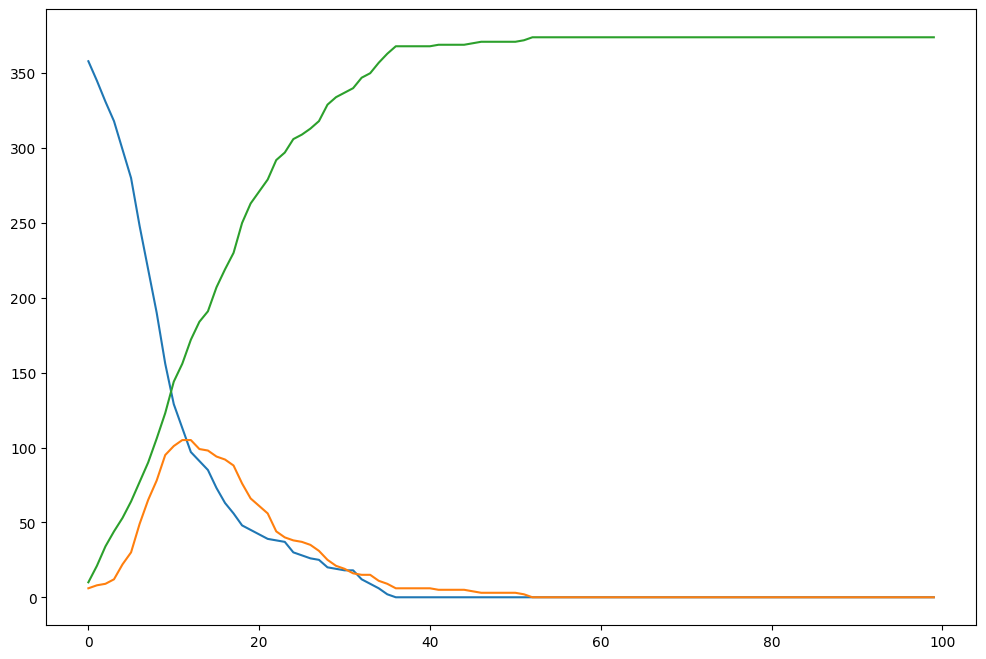

In [661]:
plt.figure(figsize=(12, 8))
plt.plot(timeSpan, S_list, label='Susceptible')
plt.plot(timeSpan, I_list, label='Infected')
plt.plot(timeSpan, R_list, label='Recovered')
plt.show()

## Vaccination Strategy

In [1027]:
beta = 0.101
gamma = 0.1

In [1028]:
timeMax = 100
timeMin = 0
timeInterval = 1
timeSpan = np.arange(timeMin, timeMax, timeInterval)

In [1047]:
NUM_INFECTED = 5

In [1048]:
""" infectedNodesRandom = []

while len(infectedNodesRandom) < 5:
    randomIndex = np.random.choice(sociopatternsNetwork.nodes())
    if randomIndex not in infectedNodesRandom:
        infectedNodesRandom.append(randomIndex)

print(infectedNodesRandom) """

' infectedNodesRandom = []\n\nwhile len(infectedNodesRandom) < 5:\n    randomIndex = np.random.choice(sociopatternsNetwork.nodes())\n    if randomIndex not in infectedNodesRandom:\n        infectedNodesRandom.append(randomIndex)\n\nprint(infectedNodesRandom) '

In [1074]:
sociopatternsVaccinationSIR = ep.SIRModel(sociopatternsNetwork)

modelConfig = mc.Configuration()
modelConfig.add_model_parameter('beta', beta)
modelConfig.add_model_parameter('gamma', gamma)


"""
Work-around for automatic infection issue using proportion of
infected for "fraction_infected" parameter.
May need to adjust if we want more specificity in our 
infected nodes selection.
"""
fractionInfected = NUM_INFECTED / sociopatternsNetwork.number_of_nodes()
modelConfig.add_model_parameter("fraction_infected", fractionInfected)



""" for n in sociopatternsNetwork.nodes():
    modelConfig.add_node_configuration("Infected", n, 0)

for i in infectedNodesRandom:
    sociopatternsVaccinationSIR.status[i] = 1 """
sociopatternsVaccinationSIR.set_initial_status(modelConfig)

for k in sociopatternsNetwork.nodes():
    if sociopatternsVaccinationSIR.status[k] == 1:
        print("Node: ", k)
        print("Degrees: ", sociopatternsNetwork.degree(k))
        print("Neighbors: ", list(sociopatternsNetwork.neighbors(k)))

Node:  1600
Degrees:  23
Neighbors:  [1428, 1523, 1525, 1529, 1544, 1519, 1583, 1549, 1553, 1599, 1825, 1458, 1517, 1438, 1888, 1756, 1645, 1681, 1821, 1664, 1683, 1884, 1890]
Node:  1453
Degrees:  15
Neighbors:  [1543, 1269, 1552, 1626, 1593, 1840, 1466, 1528, 1493, 1761, 1700, 1707, 1566, 1439, 1884]
Node:  1766
Degrees:  8
Neighbors:  [1489, 1441, 1767, 1752, 1585, 1712, 1575, 1835]
Node:  1473
Degrees:  2
Neighbors:  [1915, 1707]
Node:  1446
Degrees:  0
Neighbors:  []


In [1075]:
S_list_vacc = []
I_list_vacc = []
R_list_vacc = []

allIterationsVacc = []

colorDictionaryVacc = {}
colorsVacc = []

iterationsVacc = []

testingStack = []

TEST_LIMIT = 200

TEST_ITERATIONS_PER_T = 25

VACCINE_MAX = 10

title = 'Sociopatterns Network SIR Model Vaccination Strategy'
saveName = 'vacc_sociopatternsSIRModel.gif'

In [1076]:
testingStackDict = dict()

for i in sociopatternsNetwork:
    testingStackDict[i] = sociopatternsNetwork.degree[i]

testingStackDict = dict(sorted(testingStackDict.items(),
                            key=lambda item: item[1],
                            reverse=False))

testingStackList = list(testingStackDict.keys())

print(testingStackDict)
print(testingStackList)

{1542: 0, 1904: 0, 1435: 0, 1442: 0, 1638: 0, 1614: 0, 1685: 0, 1899: 0, 1732: 0, 1765: 0, 1656: 0, 1672: 0, 1922: 0, 1826: 0, 1836: 0, 1446: 0, 1631: 1, 1573: 1, 1461: 1, 1879: 1, 1444: 1, 1596: 1, 1612: 1, 1465: 1, 1466: 1, 1535: 1, 1433: 1, 1640: 1, 1749: 1, 1735: 1, 1595: 1, 1654: 1, 1866: 1, 1679: 1, 1728: 1, 1854: 1, 1476: 1, 1485: 1, 1478: 1, 1897: 1, 1490: 1, 1807: 1, 1768: 1, 1663: 1, 1883: 1, 1428: 2, 1602: 2, 1691: 2, 1430: 2, 1448: 2, 1839: 2, 1773: 2, 1619: 2, 1608: 2, 1457: 2, 1743: 2, 1652: 2, 1597: 2, 1564: 2, 1609: 2, 1648: 2, 1661: 2, 1577: 2, 1677: 2, 1675: 2, 1576: 2, 1725: 2, 1502: 2, 1918: 2, 1475: 2, 1484: 2, 1482: 2, 1570: 2, 1868: 2, 1873: 2, 1483: 2, 1473: 2, 1907: 2, 1818: 2, 1708: 2, 1771: 3, 1552: 3, 1629: 3, 1545: 3, 1520: 3, 1578: 3, 1641: 3, 1872: 3, 1452: 3, 1497: 3, 1460: 3, 1555: 3, 1581: 3, 1842: 3, 1496: 3, 1757: 3, 1455: 3, 1585: 3, 1645: 3, 1834: 3, 1710: 3, 1667: 3, 1664: 3, 1666: 3, 1701: 3, 1642: 3, 1651: 3, 1813: 3, 1660: 3, 1851: 3, 1687: 3, 

In [1095]:
""" 
Iterate through timesteps
    Iterate up to the test limit per iteration
        If a previous test found an infected with neighbors (neighborsOfInfected)
            Test the neighbor with the highest connectivity
                If vaccines are unavailable
                    Return the tested node to the general testing stack
                If the neighbor of the infected is susceptible
                    Vaccinate
        If no neighbors of infected need testing
            Test the next untested general node of the highest degree 
        (To-do: Remove tested neighbors from the general testing stack to minimize repeat tests per iteration) 
        
        If a tested node was infected
            Add neighbors to an array of and sort them by connectivity (neighborsOfInfected)
        
    If the max number of vaccines were not reached in this timestep
        Vaccinate tested susceptibles that were not neighbors to infecteds
    
    Append all vaccinations to iteration results
    Append S, I, R counts to respective lists

    (To-do: When no more tests are available, vaccinate randmonly)
(To-do: Set up common parameters and results for the null case and vaccine case to compare)
        
        
* Additional Notes
    Finding the nodes with the highest centraliity means very little if the 
    vaccination max per iteration is low since all the neigbors can't be vaccinated

    Spending a lot of time testing and vaccinating every neighbor of a highly central 
    node can lead to large spreads elsewhere


    
        """

" \nIterate through timesteps\n    Iterate up to the test limit per iteration\n        If a previous test found an infected with neighbors (neighborsOfInfected)\n            Test the neighbor with the highest connectivity\n                If vaccines are unavailable\n                    Return the tested node to the general testing stack\n                If the neighbor of the infected is susceptible\n                    Vaccinate\n        If no neighbors of infected need testing\n            Test the next untested general node of the highest degree \n        (To-do: Remove tested neighbors from the general testing stack to minimize repeat tests per iteration) \n        \n        If a tested node was infected\n            Add neighbors to an array of and sort them by connectivity (neighborsOfInfected)\n        \n    If the max number of vaccines were not reached in this timestep\n        Vaccinate tested susceptibles that were not neighbors to infecteds\n    \n    Append all vaccinatio

In [1078]:
neighborsOfInfected = []
totalTestsCompleted = 0
testStack = testingStackList.copy()
for i in timeSpan: # Iterate over the time span
    print("Time Loop", i)
    currentVaccCompleted = 0
    vaccDict = dict()
    nonNeighborsSusceptible = []
    #testStack = testingStackList.copy()

    for j in range(TEST_ITERATIONS_PER_T): # Test limit per iteration
        #print("Tests Loop", j)
        if totalTestsCompleted >= TEST_LIMIT: # Test limit for the entire simulation
            break
        
        if neighborsOfInfected: # If neighbors of infected nodes exist
            currentTestDict = neighborsOfInfected.pop()
            currentTestName = list(currentTestDict.keys())[0]
            print(currentTestName)
            testedNodeStatus = sociopatternsVaccinationSIR.status[currentTestName]
            if testedNodeStatus == 0: # If neighbor is susceptible, vaccinate
                if currentVaccCompleted >= VACCINE_MAX: # If the maximum number of vaccines is reached
                    print("Max Vaccines Reached")
                    testStack.append(currentTestName)
                    #neighborsOfInfected.append(currentTestDict) # Retest the node next iteration
                else: # Vaccinate if vaccines are available
                    sociopatternsVaccinationSIR.status[currentTestName] = 2
                    vaccDict[currentTestName] = 2
                    currentVaccCompleted += 1
                    print("Vaccinated Node: ", currentTestName)
        else: # If no neighbors of infected need to be tested, test the next most central node
            currentTestName = testStack.pop() # Remove element from stack
            testedNodeStatus = sociopatternsVaccinationSIR.status[currentTestName]
            if testedNodeStatus == 0:
                nonNeighborsSusceptible.append(currentTestName)

        totalTestsCompleted += 1

        print("Current Test Node: ", currentTestName)
        
        print("Total Tests: ", totalTestsCompleted)


        neighborhoodArray = []
        if testedNodeStatus == 1: # If the tested node is infected
            neighbors = sociopatternsNetwork.neighbors(currentTestName)

            for neighbor in neighbors: # Iterate over the neighbors of the infected node
                neighborDict = dict()
                neighborDict[neighbor] = sociopatternsNetwork.degree(neighbor)
                neighborsOfInfected.append(neighborDict)
        
        neighborsOfInfected = sorted(neighborsOfInfected, 
                                    key=lambda x: list(x.values())[0], 
                                    reverse=False)

        print("Neighbor Array: ", neighborsOfInfected)

    nonNeighborsSusceptible.reverse()
    while currentVaccCompleted < VACCINE_MAX:
        currentVaccCompleted += 1
        if nonNeighborsSusceptible:
            extraNonNeighbor  = nonNeighborsSusceptible.pop()
            print("Extra Vaccinated Node: ", extraNonNeighbor)
            sociopatternsVaccinationSIR.status[extraNonNeighbor] = 2
            vaccDict[extraNonNeighbor] = 2
    

    iteration = sociopatternsVaccinationSIR.iteration() # Perform an iteration

    for vacc in vaccDict:
        iteration['status'][vacc] = vaccDict[vacc]


    S_list_vacc.append(iteration['node_count'][0])
    I_list_vacc.append(iteration['node_count'][1])
    R_list_vacc.append(iteration['node_count'][2])

    allIterationsVacc.append(iteration)

Time Loop 0
Current Test Node:  1599
Total Tests:  1
Neighbor Array:  []
Current Test Node:  1825
Total Tests:  2
Neighbor Array:  []
Current Test Node:  1441
Total Tests:  3
Neighbor Array:  []
Current Test Node:  1684
Total Tests:  4
Neighbor Array:  []
Current Test Node:  1598
Total Tests:  5
Neighbor Array:  []
Current Test Node:  1525
Total Tests:  6
Neighbor Array:  []
Current Test Node:  1489
Total Tests:  7
Neighbor Array:  []
Current Test Node:  1519
Total Tests:  8
Neighbor Array:  []
Current Test Node:  1655
Total Tests:  9
Neighbor Array:  []
Current Test Node:  1767
Total Tests:  10
Neighbor Array:  []
Current Test Node:  1544
Total Tests:  11
Neighbor Array:  []
Current Test Node:  1617
Total Tests:  12
Neighbor Array:  []
Current Test Node:  1547
Total Tests:  13
Neighbor Array:  []
Current Test Node:  1628
Total Tests:  14
Neighbor Array:  []
Current Test Node:  1549
Total Tests:  15
Neighbor Array:  []
Current Test Node:  1600
Total Tests:  16
Neighbor Array:  [{1428: 

In [1079]:
colorDictionaryVacc = {}
colorsVacc = []
title = 'Sociopatterns Network SIR Model with vaccination strategy'
saveName = 'vacc_sociopatternsSIRModel.mp4'

fig = plt.figure(figsize=(12, 8))

partialFunction = partial(plotSingleNetworkInfection, 
                          modelIterations=allIterationsVacc, 
                          network=sociopatternsNetwork, 
                          layout=springLayout, 
                          colors=colorsVacc, 
                          colorDictionary=colorDictionaryVacc,
                          title=title)

gif = FuncAnimation(fig, partialFunction, frames=timeSpan, repeat=False)

gif.save(saveName, writer='ffmpeg', fps=1)
plt.close(fig)

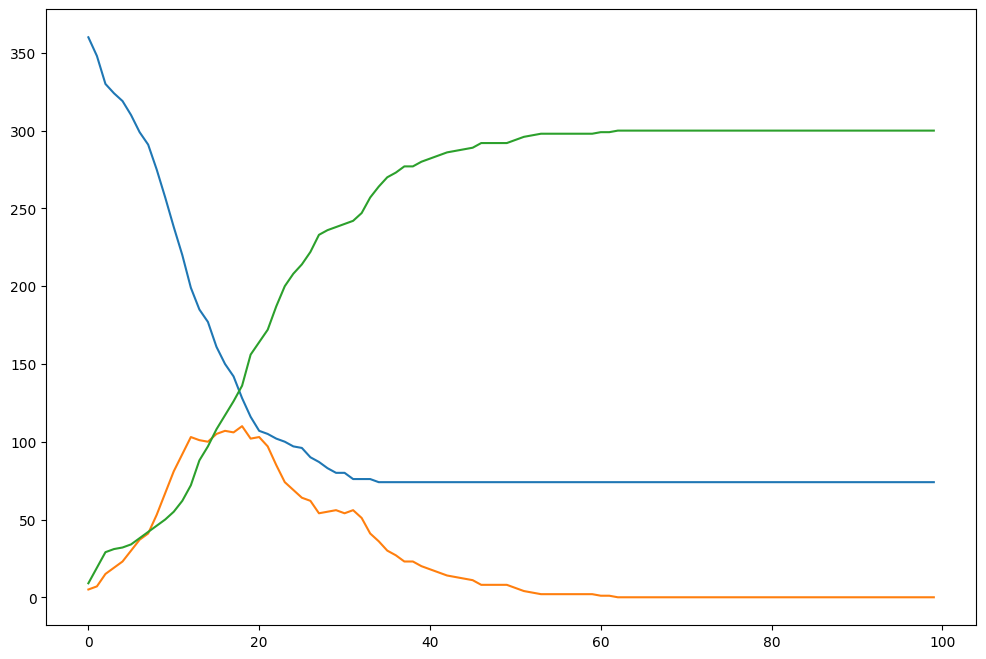

In [1080]:
plt.figure(figsize=(12, 8))
plt.plot(timeSpan, S_list_vacc, label='Susceptible')
plt.plot(timeSpan, I_list_vacc, label='Infected')
plt.plot(timeSpan, R_list_vacc, label='Recovered')
plt.show()

### Network Experimenting

C:\Users\Victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ndlib\models\DiffusionModel.py:169: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  warnings.warn(


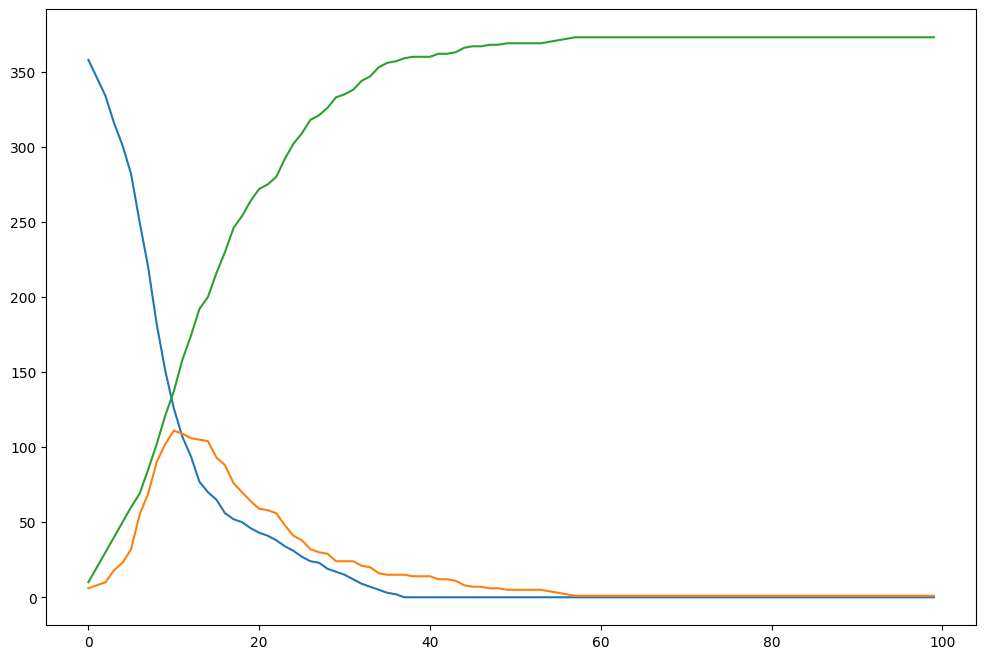

In [ ]:
VACC_NUM = 10

sociopatternsNullSIR = ep.SIRModel(sociopatternsNetwork)

modelConfig = mc.Configuration()
modelConfig.add_model_parameter('beta', beta)
modelConfig.add_model_parameter('gamma', gamma)
# modelConfig.add_model_parameter('Infected', infectedNodesRandom)
modelConfig.add_model_parameter("fraction_infected", 0.0)

for n in sociopatternsNetwork.nodes():
    modelConfig.add_node_configuration("Infected", n, 0)

vaccinationArray = list(sociopatternsNetwork.nodes())
random.shuffle(vaccinationArray)

for i in infectedNodesRandom:
    sociopatternsNullSIR.status[i] = 1
sociopatternsNullSIR.set_initial_status(modelConfig)

S_list = []
I_list = []
R_list = []

colorDictionary = {}
colors = []

title = 'Sociopatterns Network SIR Model'
saveName = 'sociopatternsSIRModel.gif'

fig = plt.figure(figsize=(12, 8))

for i in timeSpan:
    for vacc in range(VACC_NUM):
        if len(vaccinationArray) > 0:
            vaccCandidate = vaccinationArray.pop()
            if sociopatternsNullSIR.status[vaccCandidate] == 0:
                sociopatternsNullSIR.status[vaccCandidate] = 2
    iteration = sociopatternsNullSIR.iteration()
    # print(iteration)
    S_list.append(iteration['node_count'][0])
    I_list.append(iteration['node_count'][1])
    R_list.append(iteration['node_count'][2])

plt.plot(timeSpan, S_list, label='Susceptible')
plt.plot(timeSpan, I_list, label='Infected')
plt.plot(timeSpan, R_list, label='Recovered')
plt.show()

In [117]:
nodeNum = 100
edgeNum = 3

smallWattz = nx.watts_strogatz_graph(10, 2, 0.1)

barabasiNet = nx.barabasi_albert_graph(nodeNum, edgeNum)
wattsStrogatz = nx.watts_strogatz_graph(nodeNum, edgeNum, 0.1)
erdosReyni = nx.erdos_renyi_graph(nodeNum, 0.01)
binomial = nx.binomial_graph(nodeNum, 0.1)



In [118]:
barabasiDia = nx.diameter(barabasiNet)
barabasiCluster = nx.cluster.average_clustering(barabasiNet)
barabasiShortestPath = nx.average_shortest_path_length(barabasiNet)
barabasiDensity = nx.density(barabasiNet)
barabasiAssort = nx.degree_assortativity_coefficient(barabasiNet)
barabasiComponents = nx.number_connected_components(barabasiNet)

print("Barabasi-Albert Graph")
print("Diameter: ", barabasiDia)
print("Cluster Coefficient: ", barabasiCluster)
print("Average Shortest Path: ", barabasiShortestPath)
print("Density: ", barabasiDensity)
print("Assortativity: ", barabasiAssort)
print("Connected Components: ", barabasiComponents)

Barabasi-Albert Graph
Diameter:  5
Cluster Coefficient:  0.10104161198278845
Average Shortest Path:  2.6680808080808083
Density:  0.058787878787878785
Assortativity:  -0.12696844343772698
Connected Components:  1


In [200]:
X0 = 0.9
Y0 = 0.1
Z0 = 0.0
N = X0 + Y0 + Z0
beta = 0.4
gamma = 0.1
mu = 0.02

In [201]:
time = 1000
timeInterval = 1
timeSpan = np.arange(0, time, timeInterval)

{'iteration': 1, 'status': {1543: 1, 1626: 1, 1593: 1, 1466: 1, 1528: 1, 1566: 1, 1884: 1}, 'node_count': {0: 366, 1: 8, 2: 0}, 'status_delta': {0: -7, 1: 7, 2: 0}}


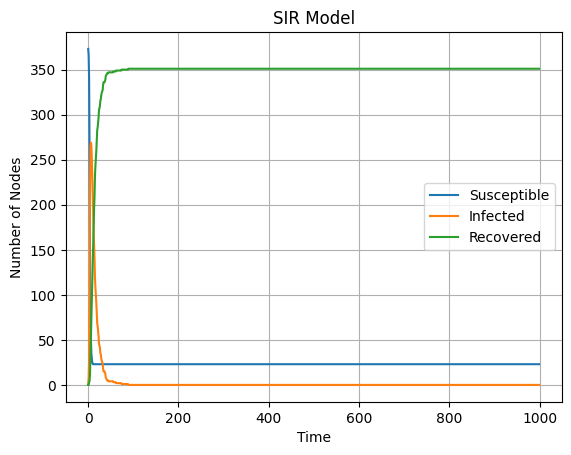

In [254]:
modelSIR = ep.SIRModel(network)

modelConfig = mc.Configuration()
modelConfig.add_model_parameter('beta', beta)
modelConfig.add_model_parameter('gamma', gamma)
modelConfig.add_model_parameter('mu', mu)

modelConfig.add_model_parameter("fraction_infected", 0.0)


for n in network.nodes():
    modelConfig.add_node_configuration("Infected", n, 0)

modelConfig.add_node_configuration("Infected", largestCentralNodeIndex, 1)

modelSIR.set_initial_status(modelConfig)

modelIterations = modelSIR.iteration_bunch(time)


iterationNum = 1
test = modelIterations[iterationNum]

print(test)

result = modelSIR.build_trends(modelIterations)


plt.figure()
for r in result:
    plt.plot(timeSpan, 
             r['trends']['node_count'][0],
             label='Susceptible')
    plt.plot(timeSpan, 
             r['trends']['node_count'][1],
             label='Infected')
    plt.plot(timeSpan, 
             r['trends']['node_count'][2],
             label='Recovered')

plt.xlabel('Time')
plt.ylabel('Number of Nodes')
plt.title('SIR Model')
plt.legend()
plt.grid(True)
plt.show()

{'iteration': 1, 'status': {1628: 1, 1593: 1, 1907: 1}, 'node_count': {0: 370, 1: 4, 2: 0}, 'status_delta': {0: -3, 1: 3, 2: 0}}


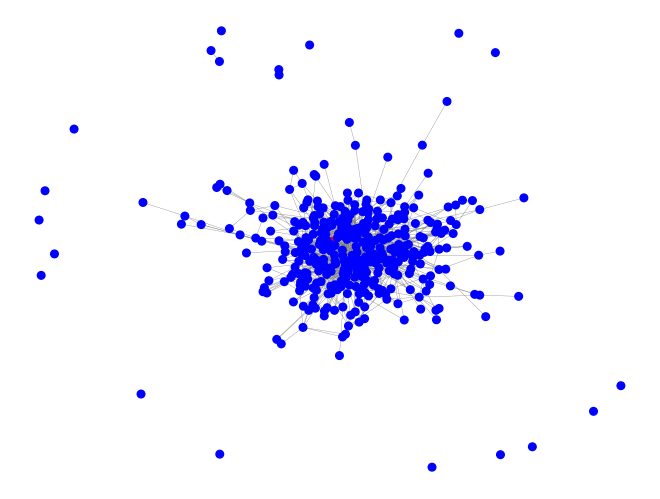

In [280]:
modelSIR = ep.SIRModel(network)

modelConfig = mc.Configuration()
modelConfig.add_model_parameter('beta', beta)
modelConfig.add_model_parameter('gamma', gamma)
modelConfig.add_model_parameter('mu', mu)

modelConfig.add_model_parameter("fraction_infected", 0.0)


for n in network.nodes():
    modelConfig.add_node_configuration("Infected", n, 0)

modelConfig.add_node_configuration("Infected", largestCentralNodeIndex, 1)

modelSIR.set_initial_status(modelConfig)

modelIterations = modelSIR.iteration_bunch(time)


iterationNum = 1
test = modelIterations[iterationNum]

print(test)

result = modelSIR.build_trends(modelIterations)


colorDictionary = {}
colors = []


for node in modelIterations[0]['status']:
    if modelIterations[0]['status'][node] == 0:
        colorDictionary[node] = 'blue'
    elif modelIterations[0]['status'][node] == 1:
        colorDictionary[node] = 'red'
    else:
        colorDictionary[node] = 'green'

colors = [colorDictionary[node] for node in network.nodes()]


layout = nx.spring_layout(network, k=0.3)

nx.draw(network,
        layout,
        node_size=30, 
        node_color = colors, 
        edge_color = 'grey', 
        width = 0.25) 



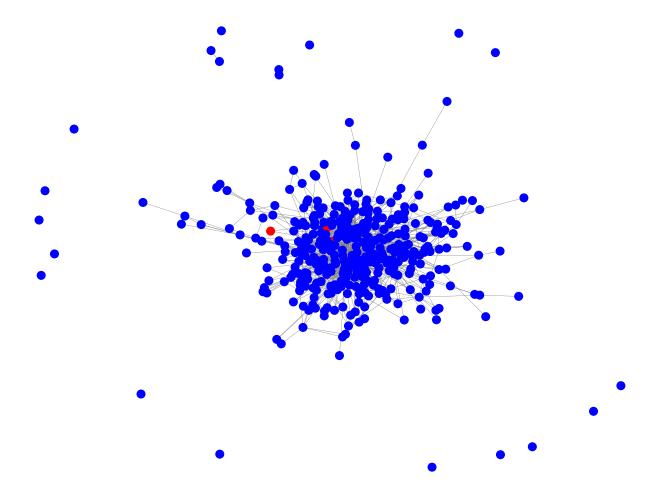

In [294]:
t = 1

for node in modelIterations[t]['status']:
    if modelIterations[t]['status'][node] == 0:
        colorDictionary[node] = 'blue'
    elif modelIterations[t]['status'][node] == 1:
        colorDictionary[node] = 'red'
    else:
        colorDictionary[node] = 'green'

colors = [colorDictionary[node] for node in network.nodes()]

nx.draw(network,
        layout,
        node_size=30, 
        node_color = colors, 
        edge_color = 'grey', 
        width = 0.25) 

[{'trends': {'node_count': {0: [373, 371, 370, 370, 369, 369, 369, 369, 369, 369, 368, 367, 367, 367, 367, 365, 363, 363, 363, 362, 361, 360, 360, 360, 356, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 354, 354, 354, 354, 350, 346, 343, 343, 343, 342, 340, 340, 336, 323, 316, 309, 305, 304, 303, 303, 298, 296, 295, 293, 292, 286, 282, 280, 275, 269, 265, 261, 253, 240, 237, 234, 232, 232, 230, 223, 217, 205, 201, 196, 195, 193, 191, 185, 185, 185, 184, 184, 184, 180, 176, 172, 166, 164, 164, 161, 158, 152, 145, 145, 144, 144, 136, 135, 134, 131, 129, 125, 122, 118, 113, 107, 106, 103, 100, 99, 97, 94, 93, 92, 89, 88, 85, 83, 82, 82, 82, 82, 82, 81, 80, 78, 77, 77, 76, 76, 76, 75, 75, 75, 74, 73, 73, 73, 73, 72, 71, 71, 67, 66, 65, 65, 65, 65, 63, 63, 61, 61, 56, 56, 54, 54, 54, 54, 53, 53, 53, 52, 52, 52, 52, 52, 51, 49, 49, 49, 49, 49, 49, 48, 48, 47, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 44, 44, 43, 43, 42, 42, 42, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 40, 40,

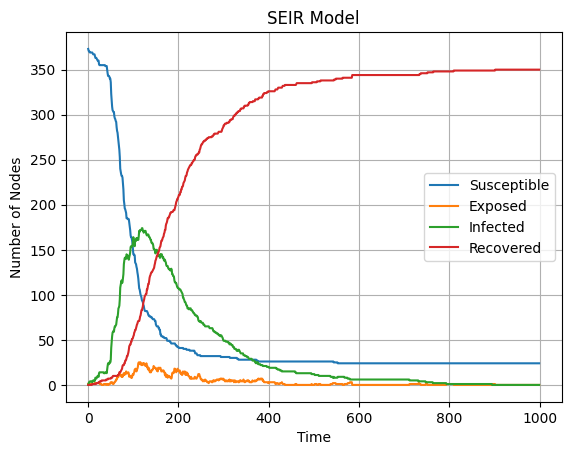

In [274]:
modelSIR = ep.SEIRModel(network)

modelConfig = mc.Configuration()
modelConfig.add_model_parameter('alpha', 0.01)
modelConfig.add_model_parameter('beta', beta)
modelConfig.add_model_parameter('gamma', gamma)
modelConfig.add_model_parameter('mu', mu)

modelConfig.add_model_parameter("fraction_infected", 0.0)


for n in network.nodes():
    modelConfig.add_node_configuration("Infected", n, 0)

modelConfig.add_node_configuration("Infected", largestCentralNodeIndex, 1)

modelSIR.set_initial_status(modelConfig)

modelIterations = modelSIR.iteration_bunch(time)

result = modelSIR.build_trends(modelIterations)

print(result)
print(result[0]['trends']['node_count'][2])

plt.figure()
for r in result:
    plt.plot(timeSpan, 
             r['trends']['node_count'][0],
             label='Susceptible')
    plt.plot(timeSpan, 
             r['trends']['node_count'][1],
             label='Exposed')
    plt.plot(timeSpan, 
             r['trends']['node_count'][2],
             label='Infected')
    plt.plot(timeSpan, 
             r['trends']['node_count'][3],
             label='Recovered')

plt.xlabel('Time')
plt.ylabel('Number of Nodes')
plt.title('SEIR Model')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
def plot_graph_spring(network):
    ax = plt.figure(figsize=(10, 10)).add_subplot()
    layout = nx.spring_layout(network)
    node_sizes = np.zeros_like(network)
    for edge in network.edges:
        node_sizes[edge[0]] += 1
        node_sizes[edge[1]] += 1
    nx.draw(network, width=0.5, pos=layout, node_size=10, ax=ax)

def plot_graph_spectral(network):
    ax = plt.figure(figsize=(10, 10)).add_subplot()
    layout = nx.spring_layout(network)
    node_sizes = np.zeros_like(network)
    for edge in network.edges:
        node_sizes[edge[0]] += 1
        node_sizes[edge[1]] += 1
    nx.draw(network, width=0.5, pos=layout, node_size=10, ax=ax)

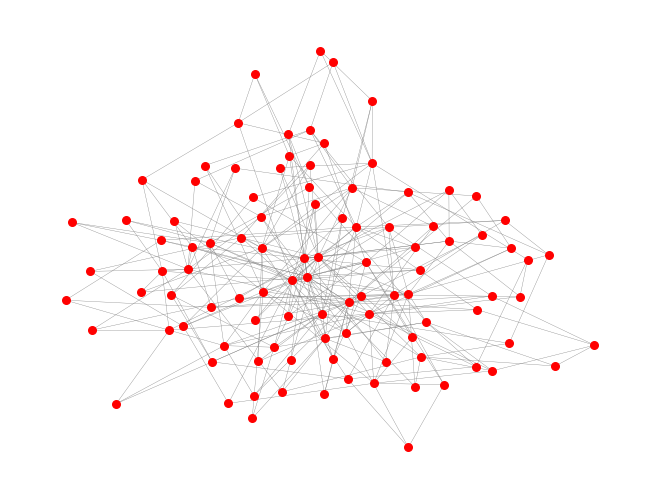

In [127]:
layout = nx.spring_layout(barabasiNet, k=0.3)

nx.draw(barabasiNet, 
        layout, 
        node_size=30, 
        node_color = 'red', 
        edge_color = 'grey', 
        width = 0.25) 

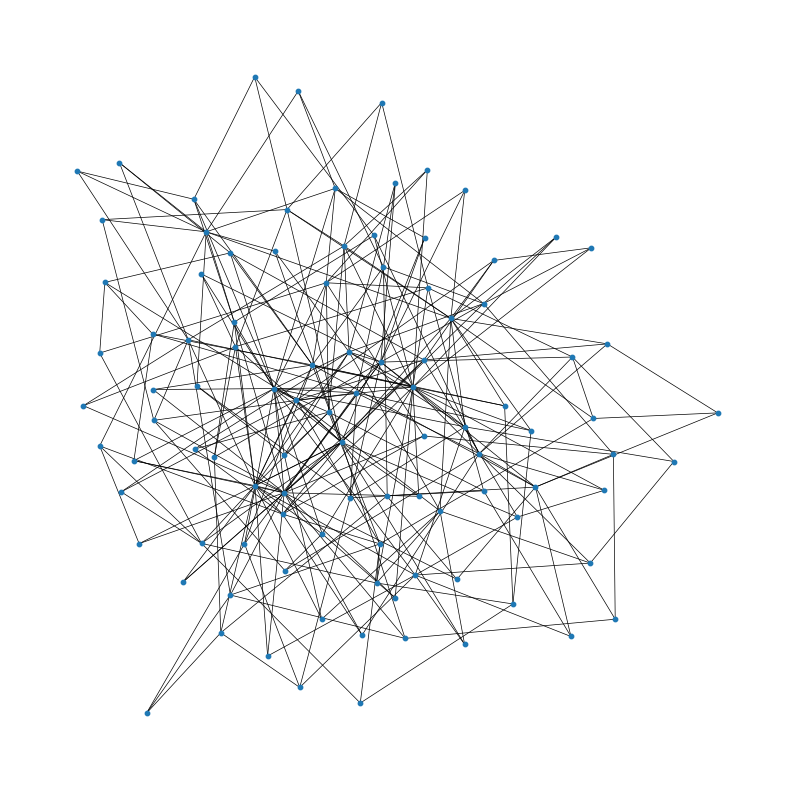

In [136]:
plot_graph_spring(barabasiNet)

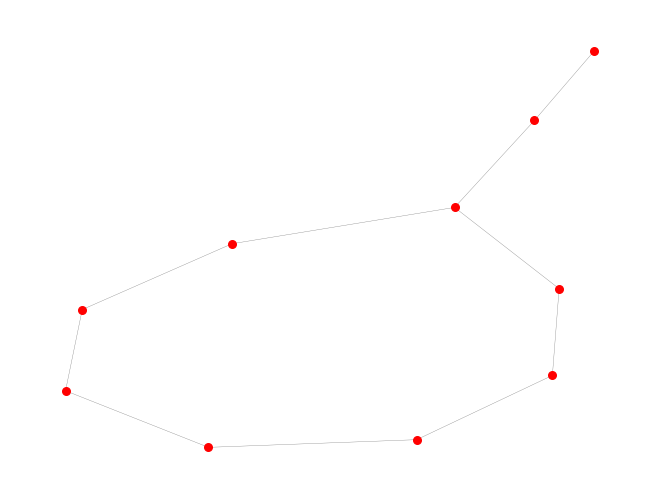

In [128]:
nx.draw(smallWattz, node_size=30, node_color = 'red', edge_color = 'grey', width = 0.25)

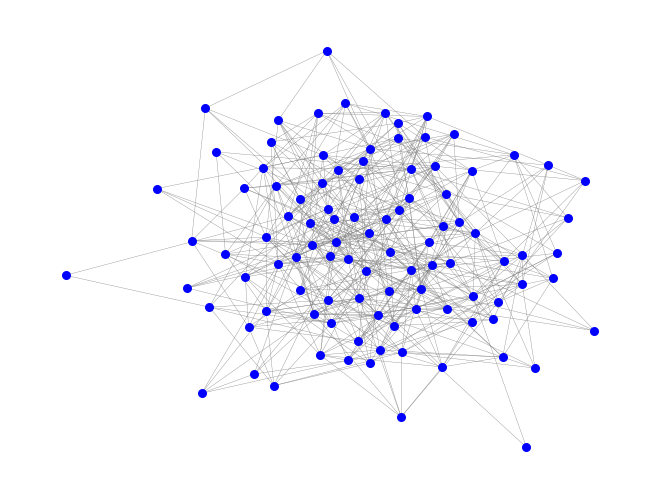

In [129]:
nx.draw(binomial, node_size=30, node_color = 'blue', edge_color = 'grey', width = 0.25)

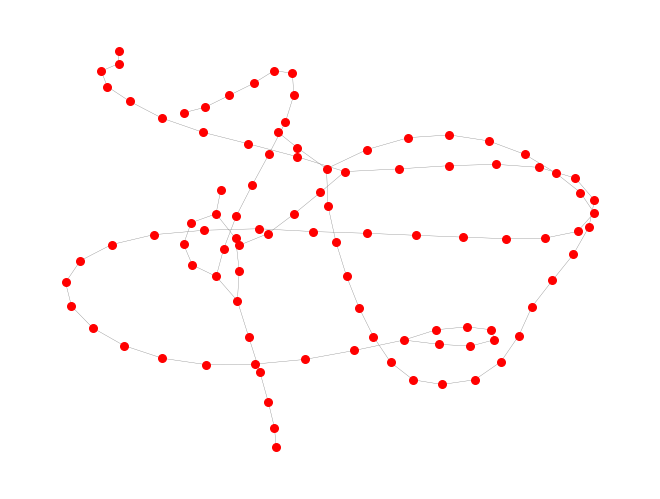

In [130]:
layout = nx.spring_layout(wattsStrogatz, k=0.3)


nx.draw(wattsStrogatz, node_size=30, node_color = 'red', edge_color = 'grey', width = 0.25) 

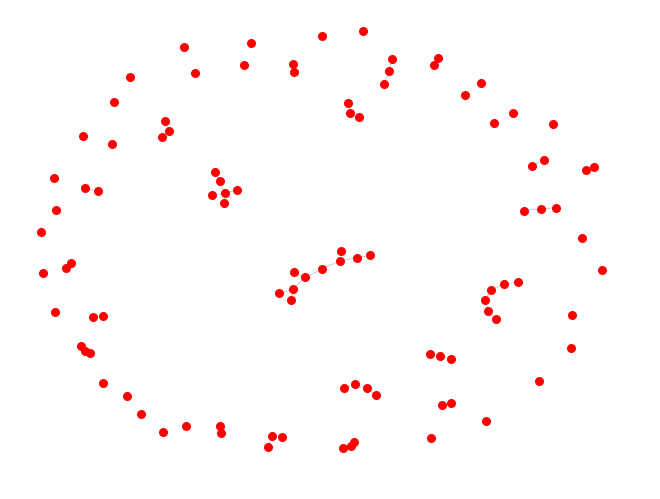

In [131]:
layout = nx.kamada_kawai_layout(erdosReyni)

nx.draw(erdosReyni, node_size=30, node_color = 'red', edge_color = 'grey', width = 0.25) 